In [1]:
from google.colab import drive 
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!7z x /content/gdrive/MyDrive/SFU/PartNet_Chairs_Scorer.7z -ogdrive/MyDrive/SFU/scorer_res


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/SFU/                                      1 file, 126434066 bytes (121 MiB)

Extracting archive: /content/gdrive/MyDrive/SFU/PartNet_Chairs_Scorer.7z
--
Path = /content/gdrive/MyDrive/SFU/PartNet_Chairs_Scorer.7z
Type = 7z
Physical Size = 126434066
Headers Size = 464237
Method = LZMA2:27
Solid = +
Blocks = 1

  0%      1% 3 - PartNet_Chairs_Scorer/negative/1095_37202_39600_43036_front.jpg                                                                          1% 36 - PartNet_Chairs_Scorer/negative/129

In [11]:
import cv2
import os
import numpy as np
import random

In [12]:
import re
def assinge_view(filename):
  top_pattern = ".*_top"
  front_pattern = ".*_front"
  side_pattern = ".*_side"

  if re.match(top_pattern,filename) is not None:
    arms,back,legs,seat,view = re.match(top_pattern,filename)[0].split("_")
    return arms,back,legs,seat,view
  elif re.match(front_pattern,filename) is not None:
    arms,back,legs,seat,view = re.match(front_pattern,filename)[0].split("_")
    return arms,back,legs,seat,view
  elif re.match(side_pattern,filename) is not None: 
    arms,back,legs,seat,view = re.match(side_pattern,filename)[0].split("_")
    return arms,back,legs,seat,view
  else:
    print("Invali filename")

In [13]:
def load (dimension):
  imagesTop = []
  imagesSide = []
  imagesFront = []
  isPositive = False
  len_negative =0
  len_positive = 0

  ls = 0

  for id, folder in enumerate(["/content/gdrive/MyDrive/SFU/scorer_res/PartNet_Chairs_Scorer/positive/","/content/gdrive/MyDrive/SFU/scorer_res/PartNet_Chairs_Scorer/negative/"]):
      isPositive = not isPositive

      length = len(os.listdir(folder)) // 3
      if isPositive:
        len_positive = length
      else:
        len_negative = length

      for filename in os.listdir(folder):

          _,_,_,_,view = assinge_view(filename)
          img = cv2.imread(folder+filename)
          img = cv2.resize(img, dsize=(dimension, dimension), interpolation=cv2.INTER_CUBIC)
          img = np.nan_to_num(img)

          if view is None:
            continue

          if img is not None:

              if view == "side":
                  imagesSide.append(1. - img / 255.)
              elif view == "top":
                  imagesTop.append(1. - img / 255.)
              else:
                  imagesFront.append(1. - img / 255.)

      if isPositive:
          y_vec_top = [[1,0]]*length 
          y_vec_side = [[1,0]]*length       
          y_vec_front =[[1,0]]*length  
      else:
          y_vec_top.extend([[0,1]]*length)  
          y_vec_side.extend([[0,1]]*length) 
          y_vec_front.extend([[0,1]]*length)                          

  return imagesTop, imagesFront, imagesSide, np.asarray(y_vec_top), np.asarray(y_vec_front), np.asarray(y_vec_side),len_positive, len_negative

In [14]:
def shuffle(imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide,len_positive,len_negative):
  shuffle_idx_pos_Top = np.random.permutation(len_positive)
  imagesTop_pos = imagesTop[:len_positive]
  imagesTop_neg = imagesTop[len_positive:]
  imagesTop_pos = imagesTop_pos[shuffle_idx_pos_Top]
  shuffle_idx_neg_Top = np.random.permutation(len_negative)
  imagesTop_neg = imagesTop_neg[shuffle_idx_neg_Top]

  shuffle_idx_pos_Front = np.random.permutation(len_positive)
  imagesFront_pos = imagesFront[:len_positive]
  imagesFront_neg = imagesFront[len_positive:]
  imagesFront_pos = imagesFront_pos[shuffle_idx_pos_Front]
  shuffle_idx_neg_Front = np.random.permutation(len_negative)
  imagesFront_neg = imagesFront_neg[shuffle_idx_neg_Front]


  shuffle_idx_pos_Side = np.random.permutation(len_positive)
  imagesSide_pos = imagesSide[:len_positive]
  imagesSide_neg = imagesSide[len_positive:]
  imagesSide_pos = imagesSide_pos[shuffle_idx_pos_Side]
  shuffle_idx_neg_Side = np.random.permutation(len_negative)
  imagesSide_neg = imagesSide_neg[shuffle_idx_neg_Side]

  labelsTop_pos = labelsTop[:len_positive]
  labelsTop_neg = labelsTop[len_positive:]
  labelsTop_pos = labelsTop_pos[shuffle_idx_pos_Top]
  labelsTop_neg = labelsTop_neg[shuffle_idx_neg_Top]

  labelsFront_pos = labelsFront[:len_positive]
  labelsFront_neg = labelsFront[len_positive:]
  labelsFront_pos = labelsFront_pos[shuffle_idx_pos_Front]
  labelsFront_neg = labelsFront_neg[shuffle_idx_neg_Front]

  labelsSide_pos = labelsSide[:len_positive]
  labelsSide_neg = labelsSide[len_positive:]
  labelsSide_pos = labelsSide_pos[shuffle_idx_pos_Side]
  labelsSide_neg = labelsSide_neg[shuffle_idx_neg_Side]
  
  return imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide


In [15]:
def get_train_test(train_slice,imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide,len_positive,len_negative):
  positive_slice = int(train_slice*len_positive)
  negative_slice = int(train_slice*len_negative)


  imagesTop_train=np.zeros((positive_slice+negative_slice, imagesTop.shape[1],imagesTop.shape[2],imagesTop.shape[3]))
  imagesTop_train[:positive_slice] = imagesTop[:positive_slice]
  imagesTop_train[positive_slice:]  = imagesTop[positive_slice:positive_slice+negative_slice]

  imagesFront_train=np.zeros((positive_slice+negative_slice, imagesFront.shape[1],imagesFront.shape[2],imagesFront.shape[3]))
  imagesFront_train[:positive_slice] = imagesFront[:positive_slice]
  imagesFront_train[positive_slice:]  = imagesFront[positive_slice:positive_slice+negative_slice]

  imagesSide_train=np.zeros((positive_slice+negative_slice, imagesSide.shape[1],imagesSide.shape[2],imagesSide.shape[3]))
  imagesSide_train[:positive_slice] = imagesSide[:positive_slice]
  imagesSide_train[positive_slice:]  = imagesSide[positive_slice:positive_slice+negative_slice]

  labelsTop_train=np.zeros((positive_slice+negative_slice,2))
  labelsTop_train[:positive_slice] = labelsTop[:positive_slice]
  labelsTop_train[positive_slice:]  = labelsTop[positive_slice:positive_slice+negative_slice]

  labelsFront_train=np.zeros((positive_slice+negative_slice,2))
  labelsFront_train[:positive_slice] = labelsFront[:positive_slice]
  labelsFront_train[positive_slice:]  = labelsFront[positive_slice:positive_slice+negative_slice]

  labelsSide_train=np.zeros((positive_slice+negative_slice,2))
  labelsSide_train[:positive_slice] = labelsSide[:positive_slice]
  labelsSide_train[positive_slice:]  = labelsSide[positive_slice:positive_slice+negative_slice]

  len_test = len_positive - positive_slice + len_negative - negative_slice

  imagesTop_test=np.zeros((len_test, imagesTop.shape[1],imagesTop.shape[2],imagesTop.shape[3]))
  imagesTop_test[:len_positive - positive_slice] =  imagesTop[positive_slice:len_positive]
  imagesTop_test[len_positive - positive_slice:]  = imagesTop[len_positive+negative_slice:]

  imagesFront_test=np.zeros((len_test, imagesFront.shape[1],imagesFront.shape[2],imagesFront.shape[3]))
  imagesFront_test[:len_positive - positive_slice] = imagesFront[positive_slice:len_positive]
  imagesFront_test[len_positive - positive_slice:]  = imagesFront[len_positive+negative_slice:]

  imagesSide_test=np.zeros((len_test, imagesSide.shape[1],imagesSide.shape[2],imagesSide.shape[3]))
  imagesSide_test[:len_positive - positive_slice] = imagesSide[positive_slice:len_positive]
  imagesSide_test[len_positive - positive_slice:]  = imagesSide[len_positive+negative_slice:]

  labelsTop_test=np.zeros((len_test,2))
  labelsTop_test[:len_positive - positive_slice] =  labelsTop[positive_slice:len_positive]
  labelsTop_test[len_positive - positive_slice:]  = labelsTop[len_positive+negative_slice:]

  labelsFront_test=np.zeros((len_test,2))
  labelsFront_test[:len_positive - positive_slice] = labelsFront[positive_slice:len_positive]
  labelsFront_test[len_positive - positive_slice:]  = labelsFront[len_positive+negative_slice:]

  labelsSide_test=np.zeros((len_test,2))
  labelsSide_test[:len_positive - positive_slice] = labelsSide[positive_slice:len_positive]
  labelsSide_test[len_positive - positive_slice:]  = labelsSide[len_positive+negative_slice:]

  train_images = []
  train_labels = []

  test_images = []
  test_labels = []

  train_images.append(imagesTop_train)
  train_images.append(imagesFront_train)
  train_images.append(imagesSide_train)

  train_labels.append(labelsTop_train)
  train_labels.append(labelsFront_train)
  train_labels.append(labelsSide_train)

  test_images.append(imagesTop_test)
  test_images.append(imagesFront_test)
  test_images.append(imagesSide_test)

  test_labels.append(labelsTop_test)
  test_labels.append(labelsFront_test)
  test_labels.append(labelsSide_test)

  return train_images,train_labels, test_images, test_labels

In [16]:
import tensorflow as tf
from tensorflow import  keras

def cnn_model_fn(input_size=(56,56,3)):
    model = keras.Sequential([
        # Input layer, change 56 to whatever the dimensions of the input images are
        keras.layers.InputLayer(input_shape=input_size),
        # keras.layers.Reshape((56, 56,1),name="reshape1"),
        # keras.layers.Flatten(name="flatten1"),

        # Conv Layer #1
        keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='same', kernel_regularizer=keras.regularizers.l2(0.1),activation="relu",name="conv1"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='same',kernel_regularizer=keras.regularizers.l2(0.1), activation="relu",name="conv2"),
        keras.layers.BatchNormalization(),

        # Pooling Layer #1
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2),name="max1"),

        # Conv Layer #2
        keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='same', kernel_regularizer=keras.regularizers.l2(0.1) ,activation="relu",name = "conv3"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=[3, 3], padding='same', kernel_regularizer=keras.regularizers.l2(0.1) ,activation="relu",name = "conv4"),
        keras.layers.BatchNormalization(),

        # Pooling Layer #2
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name = "max2"),

        # Dense Layer
        keras.layers.Flatten(name="reshape2"),
        keras.layers.Dense(units=1024, activation="relu", kernel_regularizer=keras.regularizers.l2(0.1) ,name="dense1"),
        keras.layers.Dense(units=512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.1) ,name="dense2"),
        keras.layers.Dense(units=128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.1) ,name="dense3"),
        # keras.layers.Dense(units=1024, activation="relu", name="dense1"),
        # keras.layers.Dropout(rate=0.4,name = "dropout1"),

        # Logits Layer
        keras.layers.Dense(units=2,activation="softmax",name="out")
    ])
    return model

In [17]:
imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide,len_positive,len_negative = load(56)

In [18]:
imagesTop = np.array(imagesTop)
imagesFront = np.array(imagesFront)
imagesSide = np.array(imagesSide)
labelsTop = np.array(labelsTop)
labelsFront = np.array(labelsFront)
labelsSide = np.array(labelsSide)

print(imagesTop.shape)
print(labelsTop.shape)


(12402, 56, 56, 3)
(12402, 2)


In [19]:
imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide = shuffle(imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide,len_positive,len_negative)

In [20]:
train_slice = 0.8
train_images,train_labels,test_images,test_labels = get_train_test(train_slice,imagesTop, imagesFront, imagesSide, labelsTop, labelsFront, labelsSide,len_positive,len_negative)

print(imagesTop.shape)
print(labelsTop.shape)
print(len(train_images))
print(len(test_images))
print(train_images[0].shape)
print(test_images[0].shape)
print(len(train_labels))
print(len(test_labels))
print(train_labels[0].shape)
print(test_labels[0].shape)

(12402, 56, 56, 3)
(12402, 2)
3
3
(9920, 56, 56, 3)
(2482, 56, 56, 3)
3
3
(9920, 2)
(2482, 2)


In [21]:
classifier_top = cnn_model_fn()
classifier_front= cnn_model_fn()
classifier_side = cnn_model_fn()
classifier_top.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
classifier_front.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
classifier_side.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
classifier_top.summary()

filepath = "/content/gdrive/MyDrive/SFU/best_"+"top_aug.h5"
model_checkpoint_callback_top = tf.keras.callbacks.ModelCheckpoint(
filepath, monitor='val_loss', verbose=0, save_best_only=True)

filepath= "/content/gdrive/MyDrive/SFU/best_"+"front_aug.h5"
model_checkpoint_callback_side = tf.keras.callbacks.ModelCheckpoint(
filepath, monitor='val_loss', verbose=0, save_best_only=True)

filepath = "/content/gdrive/MyDrive/SFU/best_"+"side_aug.h5"
model_checkpoint_callback_front = tf.keras.callbacks.ModelCheckpoint(
filepath, monitor='val_accuracy', verbose=0, save_best_only=True)

print("training for "+"top")
hist_top = classifier_top.fit( train_images[0],train_labels[0],batch_size=32, epochs=20,shuffle=True, validation_data=(test_images[0],test_labels[0]),callbacks=[model_checkpoint_callback_top],verbose=1)

print("training for "+"front")
hist_front = classifier_front.fit( train_images[1],train_labels[1],batch_size=32, epochs=20,shuffle=True, validation_data=(test_images[1],test_labels[1]),callbacks=[model_checkpoint_callback_front],verbose=1)

print("training for "+"side")
hist_side = classifier_side.fit( train_images[2],train_labels[2],batch_size=32, epochs=20,shuffle=True, validation_data=(test_images[2],test_labels[2]),callbacks=[model_checkpoint_callback_side],verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       5

In [22]:
import matplotlib.pyplot as plt

def draw_grapsh(hist,model_name,measure):
  val_measure = 'val_'+ measure
  plt.plot(hist.history[measure],label= "Training")
  plt.plot(hist.history[val_measure], label = "Validation")
  plt.xlabel("Epochs")
  plt.ylabel(measure.capitalize())
  plt.legend()
  plt.title(model_name+" "+ measure.capitalize()+ " Graph")
  plt.grid(True)
  plt.show()
  folder = "/content/gdrive/MyDrive/SFU/graphs"
  plt.savefig(folder+model_name+" "+ measure.capitalize()+ " Graph")

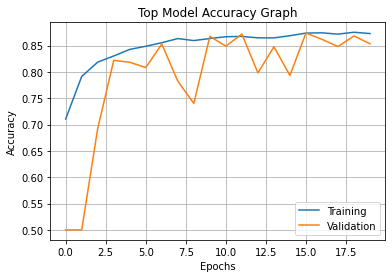

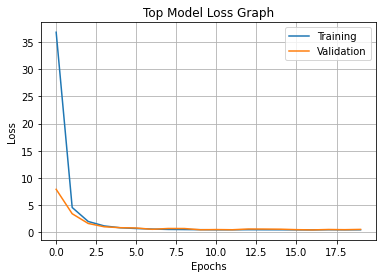

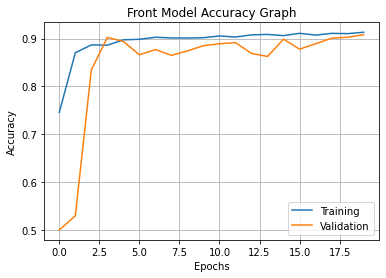

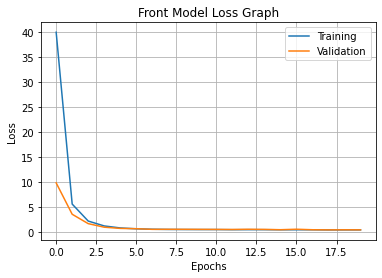

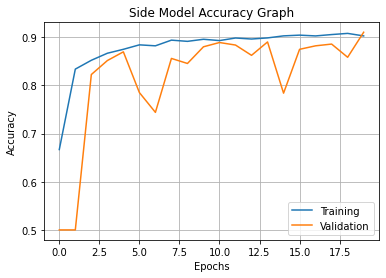

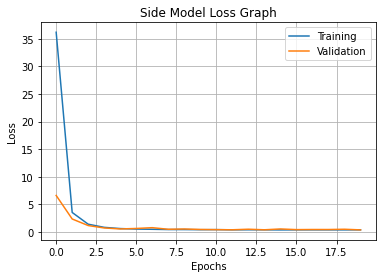

<Figure size 432x288 with 0 Axes>

In [23]:
draw_grapsh(hist_top,"Top Model","accuracy")
draw_grapsh(hist_top,"Top Model","loss")
draw_grapsh(hist_front,"Front Model","accuracy")
draw_grapsh(hist_front,"Front Model","loss")
draw_grapsh(hist_side,"Side Model","accuracy")
draw_grapsh(hist_side,"Side Model","loss")